# Data generation and fitting

### Fitting algorithm

In [29]:
from time import monotonic
import cProfile
from typing import Any
import argparse
import sys
import numpy as np
import scipy.optimize
import math
import os
import time
import pybigtools

def fitfunction(list, v0, st0, fit_step, maxiter, err_threshold, saveQ, info):
    
    timel = list
    
    v = v0
    st = st0
    exp_v = np.exp(-1/v)
    x00 = np.array([(math.pi/(4*v))*i**(-2) for i in timel])
    lm = 1000 # Remove end regions for error calculation
    
    # VECTORIZED APPROACH
    
    def mse(y_true, y_pred):
        mse_value = sum((yt - yp) ** 2 for yt, yp in zip(y_true, y_pred)) / len(y_true)
        return mse_value
    
    def fast_roll_add(dst, src, shift):
        dst[shift:] += src[:-shift]
        dst[:shift] += src[-shift:]
    
    # Expected replication time computation (replaces bcs)
    def fp(x, L, v):
        n = len(x)
        y = np.zeros(n)
    
        last_exp_2_raw = np.zeros(n)
        last_exp_2 = np.ones(n)
        unitary = x.copy()
        for k in range(L+1):
            if k != 0:
                fast_roll_add(unitary, x, k)
                fast_roll_add(unitary, x, -k)
            exp_1_raw = last_exp_2_raw
            exp_1 = last_exp_2
            exp_2_raw = exp_1_raw + unitary / v
            exp_2 = np.exp(-exp_2_raw)
    
            # Compute the weighted sum for each j and add to the total
            y += (exp_1 - exp_2) / unitary
            
            last_exp_2_raw = exp_2_raw
            last_exp_2 = exp_2
        return y

    # Fitting iteration
    def fitf(time, lst, x0, j, fit_step):
        return x0[j] * (lst[j] / time[j])**(fit_step)

    # Alternative fitting
    def fitf0(time, lst, x0, j, fit_step):
        return x0[j]**(np.log(time[j]) / np.log(lst[j]))

    # Fitting control
    def cfit(time, lst, x0, fit_step):
        result = np.empty_like(x0)
        for j in range(len(x0)):
            fit_result = fitf(time, lst, x0, j, fit_step)
            if fit_result < 10**(-err_threshold):
                result[j] = 10**(-err_threshold)
            #elif abs(time[j] - lst[j]) < .5:
            #    result[j] = x0[j]
            else:
                result[j] = fit_result       
        return result
    
    xs = x00
    ys = fp(xs, len(xs)//st, v)
    err = 10**10
    
    for j in range(maxiter):
        xs0 = xs
        ys0 = ys
        xs = cfit(timel, ys, xs, fit_step)
        ys = fp(xs, len(xs)//st, v)
        
        new_err = mse(timel[lm:-lm], ys[lm:-lm])
        print(str(j+1) + '/' + str(maxiter) + ' err: ' + str('{:.30f}'.format(new_err)), end="\r")
        
        err = new_err  # Update the error with the new calculated error

    fire_rates = ['{:.30f}'.format(i) for i in xs]
    time_sim = ys
    
    if saveQ:
        with open(r'data/whole-genome_firing_rates/fire_rates_'+info+'.txt', 'w') as f:
            for rate in fire_rates:
                f.write(rate + '\n')
        np.savetxt(r'data/whole-genome_timing_simulation/time_sim_'+info+'.txt', time_sim, fmt='%.30f')
    
    return [fire_rates, time_sim]

### Data generation

In [23]:
def datagenf(cell_line, chr, minp, maxp, resolution, alld, dtscale, saveQ, info):

    file_path = 'data/bigwig_files/'+cell_line+'.bigWig'
    bw = pybigtools.open(open(file_path, 'rb'))
    time_data_all = bw.values('chr'+str(chr))
    
    if alld == False:
        time_data_all = bw.values('chr'+str(chr), minp*resolution, maxp*resolution)
    
    # Sample equally spaced values from `time_data_all` with the given resolution
    time_data = np.array(time_data_all[::resolution])
    
    # Find positions with 'nan' or less than 0
    invalid_positions = np.where(np.isnan(time_data) | (time_data <= 0))[0]
    
    # Filter the time_data
    time_data = np.nan_to_num(time_data, nan=0.001)  # Map 'nan' to 0
    time_data[time_data <= 0] = 0.001  # Map values less than 0 to 0.001
    time_data[time_data > 100] = 100  # Map values greater than 100 to 100
    time_data = dtscale * time_data

    if saveQ: # Option to save real timing data (Repli-Seq) as a separate .txt file (not used)
        np.savetxt(f"data/whole-genome_timing_data/time_data_{info}.txt", time_data, fmt='%.30f')
        np.savetxt(f"data/whole-genome_missing_data/missing_data_{info}.txt", invalid_positions, fmt='%d')
    
    return time_data

### Generate data (replace bigWig files)

In [119]:
# Define cell lines
cell_lines = ["HeLa-S3","BJ1","IMR90","HUVEC","K562","GM12878","HepG2","MCF-7"]

# Loop over cell lines, chromosomes, and intervals
for cell_line in cell_lines:
    for chr_number in range(1, 23):
        file_name = cell_line+'_chr['+str(chr_number)+']'
        datagenf(cell_line, chr_number, 0, 1, resolution=1000, alld=True, dtscale=5, saveQ=True, info=file_name)

### Simple data generation function

In [25]:
def datagenfs(cell_line, chr_number, chrpos_min, chrpos_max, resolution, alld, dtscale, saveQ, info):
    if alld:
        time_data = np.loadtxt('data/whole-genome_timing_data/time_data_'+cell_line+'_chr['+str(chr_number)+'].txt', dtype=float)
    else:
        time_data = np.loadtxt('data/whole-genome_timing_data/time_data_'+cell_line+'_chr['+str(chr_number)+'].txt', dtype=float)[chrpos_min:chrpos_max]
        np.savetxt(f"data/whole-genome_timing_data/time_data_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt", time_data, fmt='%.30f')
    return time_data

### Exampe: fitting

In [31]:
# Model parameters
cell_line = "HeLa-S3"
chr_number = 1
hpcQ = False
if hpcQ:
    parser = argparse.ArgumentParser()
    parser.add_argument("-cl", required=False)
    parser.add_argument("-cn", required=False)
    args = parser.parse_args()
    if len(sys.argv)>1 :
        if '-cl' in sys.argv:
            cell_line = str(args.cl)
        if '-cn' in sys.argv:
            chr_number = int(args.cn)

chrpos_min = 65000
chrpos_max = 85000
x = np.linspace(chrpos_min, chrpos_max, chrpos_max - chrpos_min)  # Chromosome positions
fork_speed = 1.4
resolution = 1000 # (1 kb)
scale_factor = 5
all_dataQ = True # Picks whether to fit an entire genome
file_name = cell_line+'_chr['+str(chr_number)+']' if all_dataQ else cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max)

# Fitting parameters
int_width = 2000
def int_widthf(time_data): return int(len(time_data)/int_width)
fit_step = 2
iterations = 100
err_threshold = 15

# Saving (Warning: might replace original files)
saveQ = True
file_name = cell_line+'_chr['+str(chr_number)+']' if all_dataQ else cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max)

# Single files #
sing_filesQ = True
if sing_filesQ:
    # Data generation
    time_data = datagenfs(cell_line, chr_number, chrpos_min, chrpos_max, resolution, all_dataQ, scale_factor, saveQ, file_name)
    # Fitting
    fire_rates, time_sim = fitfunction(time_data, fork_speed, int_widthf(time_data), fit_step, iterations, err_threshold, saveQ, file_name)

# Multiple file fitting (long computation) #
mult_fileQ = False
if mult_fileQ:
    # Whole-genome parameters
    cell_lines = ["HeLa-S3","BJ1","IMR90","HUVEC","K562","GM12878","HepG2","MCF-7"]
    chr_range = range(1,23)
    for cell_line_i in cell_lines:
        for chr_number_i in chr_range:
            print(cell_line_i+' chr '+str(chr_number_i)+'/22')
            file_name = cell_line_i+'_chr['+str(chr_number_i)+']' if all_dataQ else cell_line_i+'_chr['+str(chr_number_i)+']_'+str(chrpos_min)+'-'+str(chrpos_max)
            # Data generation
            time_data = datagenfs(cell_line_i, chr_number_i, chrpos_min, chrpos_max, resolution, all_dataQ, scale_factor, saveQ, file_name)
            # Fitting
            fire_rates, time_sim = fitfunction(time_data, fork_speed, int_widthf(time_data), fit_step, iterations, err_threshold, saveQ, file_name)

# Replication timing plots

### Plotting function

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def rt_plotf(cell_line, chr_number, chrpos_min, chrpos_max, fork_speed, scale_factor, resolution, file_name, spec_fileQ, saveQ):

    # Data loading (Warning: requires saving data in fitting procedure)
    # Choose between whole-genome files or particular simulation
    if spec_fileQ:
        time_data = np.loadtxt('data/whole-genome_timing_data/time_data_'+cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max)+'.txt', dtype=float)
        time_sim = np.loadtxt('data/whole-genome_timing_simulation/time_sim_'+cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max)+'.txt', dtype=float)
    else:
        time_data = np.loadtxt('data/whole-genome_timing_data/time_data_'+cell_line+'_chr['+str(chr_number)+'].txt', dtype=float)[chrpos_min:chrpos_max]
        time_sim = np.loadtxt('data/whole-genome_timing_simulation/time_sim_'+cell_line+'_chr['+str(chr_number)+'].txt', dtype=float)[chrpos_min:chrpos_max]
    x = np.linspace(chrpos_min, chrpos_max, chrpos_max - chrpos_min)  # Chromosome positions
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, time_data, label='data', color='gray', linewidth=4,alpha=0.6)
    plt.plot(x, time_sim, label='bcs', color='red', linewidth=4,alpha=0.6)
    plt.title(cell_line+' - Chromosome '+str(chr_number))
    plt.xlabel('Chromosome position (kb)')
    plt.ylabel('Time in S-phase (min)')
    plt.ylim(100 * scale_factor, 0)
    plt.legend()
    plt.grid(True)
    
    ax = plt.gca()
    ax.grid(False)
    ax.tick_params(axis='both', which='both', direction='out')
    for spine in ax.spines.values():
        spine.set_visible(True)
    
    # Save plot
    if saveQ:
        plt.savefig('figures/plot_RT_'+file_name+'.svg', bbox_inches='tight',transparent=True)
    
    plt.show()

### Plotting examples

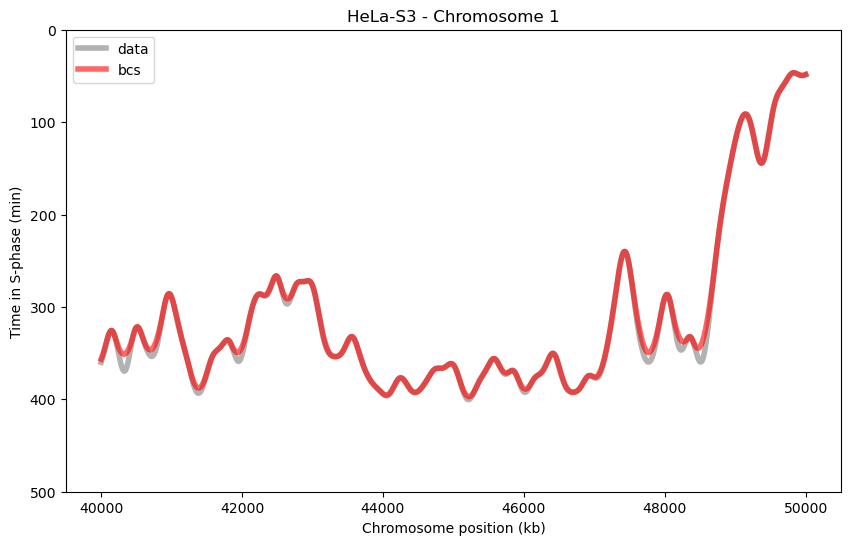

In [6]:
# Model parameters
cell_line = "HeLa-S3"
chr_number = 1
chrpos_min = 40000
chrpos_max = 50000
fork_speed = 1.4
scale_factor = 5
resolution = 1000 # (1 kb)
file_name = cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max)
saveQ = False
spec_fileQ = False

rt_plotf(cell_line, chr_number, chrpos_min, chrpos_max, fork_speed, scale_factor, resolution, file_name, spec_fileQ, saveQ)

# Fitting errors

### Error computation

In [8]:
import numpy as np
import os

def compute_squared_error(time_data, time_simulation):
    return (time_data - time_simulation) ** 2

def process_files_and_compute_squared_error(cell_lines, chr_numbers, base_path):
    for cell_line in cell_lines:
        for chr_number in chr_numbers:
            # Define file paths
            time_data_file = os.path.join(base_path, f'whole-genome_timing_data/time_data_{cell_line}_chr[{chr_number}].txt')
            time_simulation_file = os.path.join(base_path, f'whole-genome_timing_simulation/time_sim_{cell_line}_chr[{chr_number}].txt')
            error_file = os.path.join(base_path, f'whole-genome_error/error_{cell_line}_chr[{chr_number}].txt')

            # Load data
            time_data = np.loadtxt(time_data_file, dtype=float)
            time_simulation = np.loadtxt(time_simulation_file, dtype=float)

            # Compute squared error
            squared_error = compute_squared_error(time_data, time_simulation)
            
            # Save squared error to file
            np.savetxt(error_file, squared_error, fmt='%.15f')
           
# Example usage
cell_lines = ["HeLa-S3","BJ1","IMR90","HUVEC","HepG2","K562","GM12878","MCF-7"]
chr_numbers = range(1,23,1)
base_path = 'data/'
process_files_and_compute_squared_error(cell_lines, chr_numbers, base_path)


### Plotting error distribution

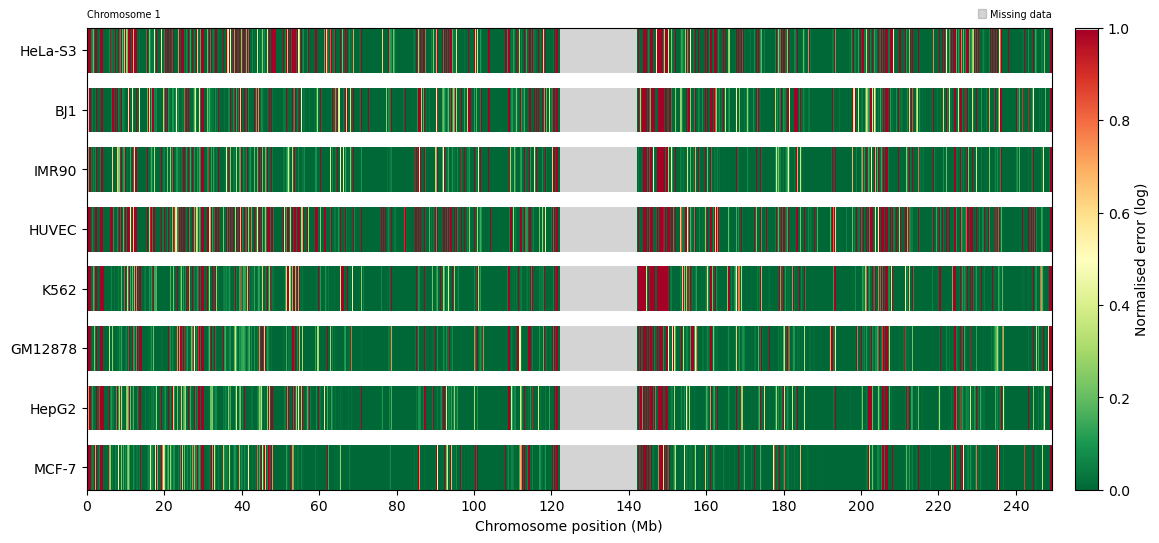

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import os

def import_squared_error(cell_line, chr_number, base_path):
    # Define file path
    error_file = os.path.join(base_path, f'whole-genome_error/error_{cell_line}_chr[{chr_number}].txt')

    # Load data
    squared_error = np.loadtxt(error_file, dtype=float)
    return squared_error

# Function to load missing data positions
def load_missing_data(cell_line, chr_number, base_path='data/whole-genome_missing_data'):
    file_path = os.path.join(base_path, f'missing_data_{cell_line}_chr[{chr_number}].txt')
    if os.path.exists(file_path):
        return np.loadtxt(file_path, dtype=int)
    else:
        return np.array([], dtype=int)

# Generate example data with larger centromere misfits and more vivid colors
chr_lengths = [249251, 243200, 198023, 191155, 180916, 171116, 159139, 146365, 141214, 135535, 135007, 133852, 115170, 107350, 102532, 90355, 81196, 78078, 59129, 63026, 48130, 51305]
cell_lines = ["HeLa-S3","BJ1","IMR90","HUVEC","K562","GM12878","HepG2","MCF-7"]
chr_number = 1
num_positions = chr_lengths[chr_number - 1]
num_cell_lines = len(cell_lines)
base_path = 'data/'

# Placeholder for goodness of fit data (use actual data from your model)
goodness_of_fit = [
    import_squared_error(cell_line, chr_number, base_path) for cell_line in cell_lines
]

# Power transformation parameter
power_param = .9  # You can tweak this parameter to change the skewness

# Apply power transformation to skew the data
transformed_goodness_of_fit = np.power(goodness_of_fit, power_param)

# Create a custom colormap for vivid red to vivid green
cmap = plt.get_cmap('RdYlGn_r')  # Note the '_r' to reverse the colormap

# Create a colormap that includes gray for the "no data" regions
colors = cmap(np.linspace(0, 1, 256))
colormap_gray = np.array([[0., 0., 0., 0.17]])  # RGBA for gray in colormap
new_colors = np.vstack((colors, colormap_gray))
extended_cmap = ListedColormap(new_colors)

# Normalize data for colormap
normalized_goodness_of_fit = np.copy(transformed_goodness_of_fit)

# Plotting with triple data plots and NaN rows between
fig, ax = plt.subplots(figsize=(15, 6))

# Create the spaced data array with triplicates and NaN rows
spaced_data = np.full((num_cell_lines * 4 - 1, num_positions), np.nan)
for i in range(num_cell_lines):
    spaced_data[i * 4] = normalized_goodness_of_fit[i]
    spaced_data[i * 4 + 1] = normalized_goodness_of_fit[i]
    spaced_data[i * 4 + 2] = normalized_goodness_of_fit[i]

# Load missing data and update goodness_of_fit
for i, cell_line in enumerate(cell_lines):
    missing_data = load_missing_data(cell_line, chr_number)  # Assuming chromosome 1 for simplicity
    spaced_data[i * 4, missing_data] = 256  # Mark missing data positions with index for gray
    spaced_data[i * 4 + 1, missing_data] = 256
    spaced_data[i * 4 + 2, missing_data] = 256

# Avoiding the maximum value being exactly 1 by subtracting a small epsilon value
spaced_data0 = spaced_data
spaced_data = np.clip(spaced_data * 255, 0, 255 - 1)  # Normalize to 0-255 range
spaced_data[spaced_data0 == 256] = 256  # Ensure missing data stays at 256

# Normalize data for colormap
cax = ax.imshow(spaced_data, aspect='auto', cmap=extended_cmap, interpolation='nearest', vmin=0, vmax=255)

# Add color bar to the right and match height of the bars on the left
cbar = fig.colorbar(cax, orientation='vertical', pad=0.02)
cbar.set_label('Normalised error (log)')
cbar.set_ticks(np.linspace(0, 255, 6))
cbar.set_ticklabels(np.round(np.linspace(0, 1, 6), 2))

# Set ticks and labels
yticks_positions = np.arange(1, num_cell_lines * 4, 4)
ax.set_yticks(yticks_positions)
ax.set_yticklabels(cell_lines)
xtick_positions = np.arange(0, num_positions, 20000)
xtick_labels = (xtick_positions / 1000).astype(int)
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('Chromosome position (Mb)')

ax.grid(False)

# Add a gray square and text for "Missing data" in the top right corner
if True:
    ax.text(0, 1.04, f'Chromosome {chr_number}', transform=ax.transAxes, fontsize=7, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor="none", edgecolor='none'))
    ax.text(1, 1.04, 'Missing data', transform=ax.transAxes, fontsize=7, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor="none", edgecolor='none'))
    ax.add_patch(plt.Rectangle((.924, 1.02), 0.008, 0.02, transform=ax.transAxes, color=[0., 0., 0., 0.17], clip_on=False))

#plt.savefig(f'figures/fig_goodness_of_fit_chr[{chr_number}].svg', bbox_inches='tight', transparent=True)

plt.show()


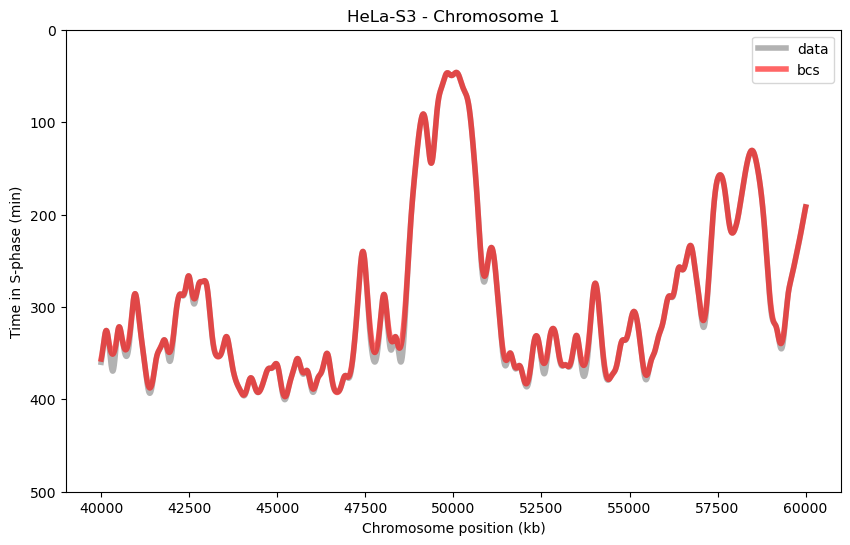

In [12]:
rt_plotf("HeLa-S3", 1, 40000, 60000,
         fork_speed=1.4, scale_factor=5, resolution=1000, file_name='', spec_fileQ=False, saveQ=False)

### Data vs data plots

In [119]:
import numpy as np
import matplotlib.pyplot as plt

def plot_replication_data_vs_data(data, labels, colors, xmin=1e-15, xmax=1e5, title="Error"):
    
    plt.figure(figsize=(10, 6))

    for (time_data, mse_data), label, color in zip(data, labels, colors):
        plt.scatter(mse_data, time_data, s=0.0000001 if label == 'Whole-genome' else 0.02, color=color, label=label)

    plt.xscale('log')
    plt.ylim(plt.ylim()[::-1])  # Invert y-axis
    plt.title('')
    plt.xlabel(title)
    plt.ylabel('Replication time (min)')
    plt.xlim((xmin, xmax))

    # Custom legend
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles = [plt.Line2D([], [], color=handle.get_facecolor()[0], marker='o', linestyle='', markersize=3) for handle in handles]
    plt.legend(handles=new_handles, labels=labels)
    
    #plt.savefig(f'figures/fig_scatter.png', bbox_inches='tight', transparent=True)
    plt.show()

def load_function(cell_line, chr_number, load_type):
    if load_type == 'time_data':
        file_path = f'data/whole-genome_timing_data/time_data_{cell_line}_chr[{chr_number}].txt'
    elif load_type == 'mse':
        file_path = f'data/whole-genome_error/error_{cell_line}_chr[{chr_number}].txt'
    elif load_type == 'fire_rates':
        file_path = f'data/whole-genome_firing_rates/fire_rates_{cell_line}_chr[{chr_number}].txt'
    return np.loadtxt(file_path, dtype=float)

### Telomores and centromeres

In [16]:
import numpy as np

def gen_centromere_telomeres(chr_number):
    # Telomere positions (start and end 500 kb)
    telomere_start = 500  # in kb
    telomere_end_offset = 500  # in kb

    # Centromere positions (in kb, hg38, approximate)
    centromere_positions_hg38 = [
        (121535, 124535), (92326, 95326), (90505, 93505), (49660, 52660),
        (46406, 49406), (58830, 61830), (58054, 61054), (43839, 46839),
        (47368, 50368), (39255, 42255), (51644, 54644), (34857, 37857),
        (16000, 19000), (16000, 19000), (17000, 20000), (35336, 38336),
        (22263, 25263), (15461, 18461), (24682, 27682), (26370, 29370),
        (11288, 14288), (13000, 16000)
    ]

    # Provided chromosome lengths (in kb)
    chromosome_lengths = [
        249251, 243200, 198023, 191155, 180916, 171116, 159139, 146365,
        141214, 135535, 135007, 133852, 115170, 107350, 102532, 90355,
        81196, 78078, 59129, 63026, 48130, 51305
    ]

    # Define additional positions to include telomeres and centromeres
    length = chromosome_lengths[chr_number - 1]
    centromere_start, centromere_end = centromere_positions_hg38[chr_number - 1]
    telomere_positions = np.concatenate([
        np.arange(0, telomere_start),
        np.arange(length - telomere_end_offset, length)
    ])
    centromere_positions = np.arange(centromere_start, centromere_end)

    return telomere_positions, centromere_positions

### Fragile sites

In [18]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", message=".*Creating legend with loc=\"best\" can be slow with large amounts of data.*")

def gen_fragile_site_positions(chr_number, site_letter):
    # Load the CSV file
    csv_path = 'data/fragile_sites/humCFS-fragile_sites.csv'
    df = pd.read_csv(csv_path, header=None)
    
    fragile_site_positions = []

    # Find the column corresponding to the given chromosome
    col_index = chr_number - 1  # Chromosome 1 corresponds to column 0, and so on

    if col_index >= df.shape[1]:
        raise ValueError(f"Chromosome {chr_number} not found in the CSV file.")

    # Find the row corresponding to the given site letter
    row_index = ord(site_letter.upper()) - ord('A')  # 'A' corresponds to row 0, 'B' to row 1, and so on

    if row_index >= df.shape[0]:
        raise ValueError(f"Site letter {site_letter} not found in the CSV file for chromosome {chr_number}.")

    # Extract the range in the form chrposmin-chrposmax
    site_range = df.iloc[row_index, col_index]

    if pd.isna(site_range):
        raise ValueError(f"No data for site {site_letter} on chromosome {chr_number}.")

    # Split the range into minimum and maximum positions
    pos_min, pos_max = map(int, site_range.split('-'))

    # Convert positions to kb
    pos_min_kb = pos_min // 1000
    pos_max_kb = pos_max // 1000

    # Append the range as a numpy array
    fragile_site_positions.append(np.arange(pos_min_kb, pos_max_kb))

    return fragile_site_positions[0]

### Other auxiliary functions

In [20]:
def generate_all_data(cell_line, chr_numbers, load_type):
    all_time_data = []
    all_mse_data = []
    for chr_number in chr_numbers:
        time_data = load_function(cell_line, chr_number, "time_data")
        mse_data = load_function(cell_line, chr_number, load_type)
        all_time_data.extend(time_data)
        all_mse_data.extend(mse_data)
    return [all_time_data, all_mse_data]

def generate_telomeres_centromeres_data(cell_line, chr_numbers_tc, load_type):
    all_time_data_t = []
    all_mse_data_t = []
    all_time_data_c = []
    all_mse_data_c = []
    for chr_number in chr_numbers_tc:
        telomere_positions, centromere_positions = gen_centromere_telomeres(chr_number)
        time_data_t = load_function(cell_line, chr_number, "time_data")[telomere_positions]
        mse_data_t = load_function(cell_line, chr_number, load_type)[telomere_positions]
        all_time_data_t.extend(time_data_t)
        all_mse_data_t.extend(mse_data_t)
        time_data_c = load_function(cell_line, chr_number, "time_data")[centromere_positions]
        mse_data_c = load_function(cell_line, chr_number, load_type)[centromere_positions]
        all_time_data_c.extend(time_data_c)
        all_mse_data_c.extend(mse_data_c)
    return [all_time_data_t, all_mse_data_t], [all_time_data_c, all_mse_data_c]

def generate_fragile_sites_data(cell_line, chr_numbers_cfs, site_letters, load_type, allcfsQ=True):
    all_time_data_cfs = []
    all_mse_data_cfs = []
    all_data_cfs = []

    for chr_number in chr_numbers_cfs:
        for site_letter in site_letters:
            fragile_site_positions = gen_fragile_site_positions(chr_number, site_letter)
            time_data_cfs = load_function(cell_line, chr_number, "time_data")[fragile_site_positions]
            mse_data_cfs = load_function(cell_line, chr_number, load_type)[fragile_site_positions]

            if allcfsQ:
                all_time_data_cfs.extend(time_data_cfs)
                all_mse_data_cfs.extend(mse_data_cfs)
            else:
                all_data_cfs.extend([[time_data_cfs, mse_data_cfs]])

    if allcfsQ:
        all_data_cfs = [[all_time_data_cfs, all_mse_data_cfs]]

    return all_data_cfs

def generate_plot(load_type, cell_line, chr_numbers, chr_numbers_tc, chr_numbers_cfs, site_letters,
                  show_whole_genome=True, show_telomeres=False, show_centromeres=False, 
                  show_fragile_sites=True, allcfsQ=False, xmin=1e-15, xmax=1e-3):
    
    title = "Error" if load_type == "mse" else "Firing rate"

    all_data = []
    labels = []
    colours = []

    if show_whole_genome:
        all_data.append(generate_all_data(cell_line, chr_numbers, load_type))
        labels.append("Whole-genome")
        colours.append('#1f77b4')

    if show_telomeres:
        data_t, data_c = generate_telomeres_centromeres_data(cell_line, chr_numbers_tc, load_type)
        all_data.append(data_t)
        labels.append("Telomeres")
        colours.append('orange')

    if show_centromeres:
        data_t, data_c = generate_telomeres_centromeres_data(cell_line, chr_numbers_tc, load_type)
        all_data.append(data_c)
        labels.append("Centromeres")
        colours.append('green')

    if show_fragile_sites:
        all_data_cfs = generate_fragile_sites_data(cell_line, chr_numbers_cfs, site_letters, load_type, allcfsQ)
        all_data.extend(all_data_cfs)
        labels.extend(["Fragile sites"] if allcfsQ else [f"FRA{chr_number}{site_letter}" for chr_number in chr_numbers_cfs for site_letter in site_letters])
        colours.extend(list(plt.cm.autumn(np.linspace(0, .5, len(labels) - len(colours)))))

    plot_replication_data_vs_data(all_data, labels, colours, xmin, xmax, title=title)

### Scatter plots

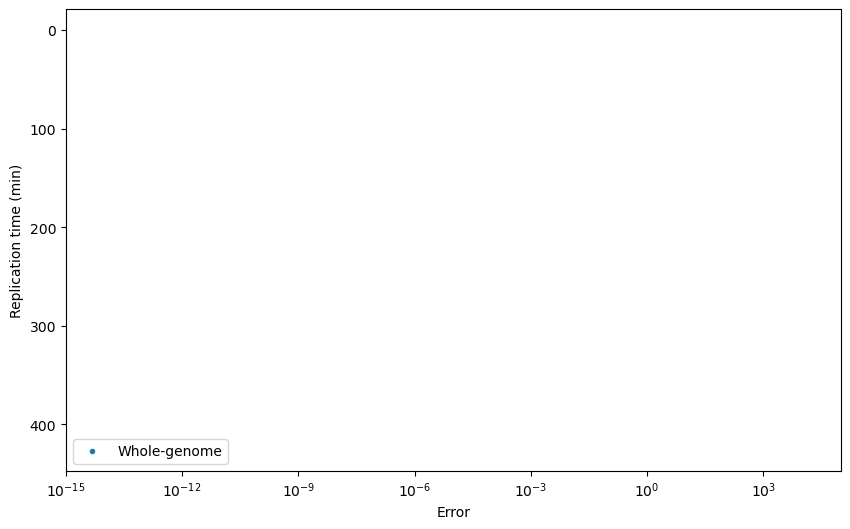

In [121]:
# Example usage
generate_plot(
    load_type="mse",
    cell_line="HeLa-S3",
    chr_numbers=range(1,23),
    chr_numbers_tc=[1],
    chr_numbers_cfs=[1],
    site_letters=['C'],
    show_whole_genome=True,
    show_telomeres=False,
    show_centromeres=False,
    show_fragile_sites=False,
    allcfsQ=False,
    xmin=1e-15,
    xmax=1e5
)

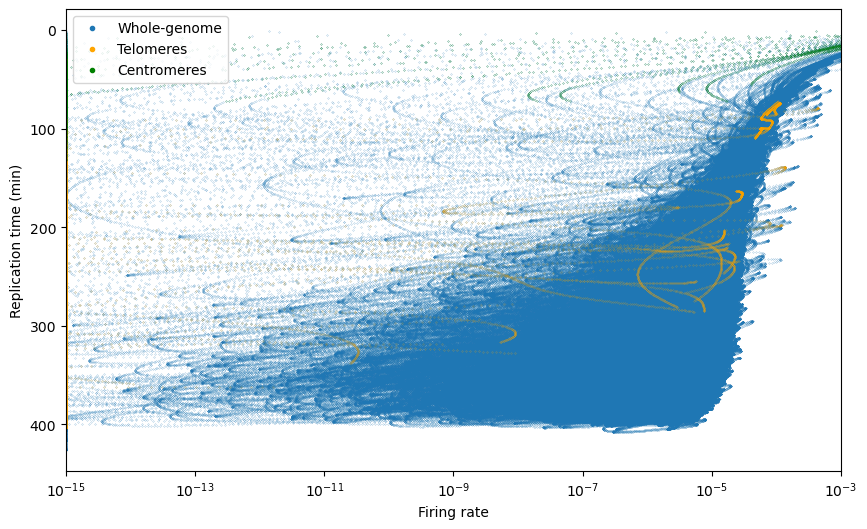

In [46]:
# Example usage
generate_plot(
    load_type="fire_rates",
    cell_line="HeLa-S3",
    chr_numbers=range(1,23),
    chr_numbers_tc=range(1,23),
    chr_numbers_cfs=[1],
    site_letters=['C'],
    show_whole_genome=True,
    show_telomeres=True,
    show_centromeres=True,
    show_fragile_sites=False,
    allcfsQ=False,
    xmin=1e-15,
    xmax=1e-3
)

### Error KDE plot function

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

def plot_relative_kdes(data_list, labels, bw_adjust=1, x_grid_size=1000, log_scale=False, x_min=None, x_max=None, plot_title="Relative density plots", x_title="Error", save_name="savedfile"):
    if log_scale:
        # Filter out non-positive values for log scale
        data_list = [data[data > 0] for data in data_list]
        if x_min is None:
            x_min = min(data.min() for data in data_list)
        if x_max is None:
            x_max = max(data.max() for data in data_list)
        x = np.logspace(np.log10(x_min), np.log10(x_max), x_grid_size)
    else:
        if x_min is None:
            x_min = min(data.min() for data in data_list)
        if x_max is None:
            x_max = max(data.max() for data in data_list)
        x = np.linspace(x_min, x_max, x_grid_size)

    plt.figure(figsize=(6, 6))

    # Compute and plot the KDEs
    ax = sns.kdeplot(data_list, fill=True, bw_adjust=bw_adjust, log_scale=log_scale)#, alpha=.5)
    handles = [mpatches.Patch(facecolor=color, label=label, alpha=0.5) for color, label in zip(plt.rcParams['axes.prop_cycle'].by_key()['color'], labels)]

    plt.title(plot_title)
    plt.xlabel(x_title)
    
    plt.gca().yaxis.set_visible(False)  # Remove y-axis ticks
    plt.ylabel('')  # Remove y-axis label
    '''
    if log_scale:
        plt.xscale('log')
        plt.xticks(ticks=np.logspace(np.floor(np.log10(x_min)), np.ceil(np.log10(x_max)), 
                                     num=int(np.ceil(np.log10(x_max)) - np.floor(np.log10(x_min))) + 1), 
                   labels=[f'$10^{{{int(i)}}}$' for i in np.arange(np.floor(np.log10(x_min)), np.ceil(np.log10(x_max)) + 1)])
    '''
    if log_scale:
        plt.xscale('log')
        exponent_jump = 2  # default value, you can adjust this parameter as needed
        plt.xticks(
            ticks=np.logspace(
                np.floor(np.log10(x_min)), 
                np.ceil(np.log10(x_max)), 
                num=int((np.ceil(np.log10(x_max)) - np.floor(np.log10(x_min))) / exponent_jump) + 1
            ), 
            labels=[
                f'$10^{{{int(i)}}}$' for i in np.arange(
                    np.floor(np.log10(x_min)), 
                    np.ceil(np.log10(x_max)) + 1, 
                    exponent_jump
                )
            ]
        )

    
    plt.xlim(x_min, x_max)
    plt.legend(handles=handles)
    plt.savefig(f'figures/fig_kdeplot_{save_name}.svg', bbox_inches='tight', transparent=True)
    plt.show()

### Error distribution: Early vs late replication

In [50]:
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

def load_time_data(cell_line, chr_number):
    file_path = f'data/whole-genome_timing_data/time_data_{cell_line}_chr[{chr_number}].txt'
    return np.loadtxt(file_path, dtype=float)

def load_error_data(cell_line, chr_number):
    file_path = f'data/whole-genome_error/error_{cell_line}_chr[{chr_number}].txt'
    return np.loadtxt(file_path, dtype=float)

def load_missing_data(cell_line, chr_number):
    file_path = f'data/whole-genome_missing_data/missing_data_{cell_line}_chr[{chr_number}].txt'
    if os.path.exists(file_path):
        return np.loadtxt(file_path, dtype=int)
    else:
        return np.array([], dtype=int)

def gen_error_late_early(cell_lines, chr_numbers, tmin, t1, t2, tmax):
    all_early_errors = []
    all_late_errors = []

    for cell_line in cell_lines:
        for chr_number in chr_numbers:
            time_data = load_time_data(cell_line, chr_number)
            error_data = load_error_data(cell_line, chr_number)
            missing_data = load_missing_data(cell_line, chr_number)

            # Remove missing data points
            if len(missing_data) > 0:
                time_data = np.delete(time_data, missing_data)
                error_data = np.delete(error_data, missing_data)

            # Split the data into early and late replication based on the time intervals
            early_errors = error_data[(time_data >= tmin) & (time_data <= t1)]
            late_errors = error_data[(time_data >= t2) & (time_data <= tmax)]

            # Add to the overall lists
            all_early_errors.extend(early_errors)
            all_late_errors.extend(late_errors)

    # Ensure no zero values before log transformation
    all_early_errors = np.array(all_early_errors)
    all_late_errors = np.array(all_late_errors)
    all_early_errors = all_early_errors[all_early_errors > 0]
    all_late_errors = all_late_errors[all_late_errors > 0]

    return all_early_errors, all_late_errors

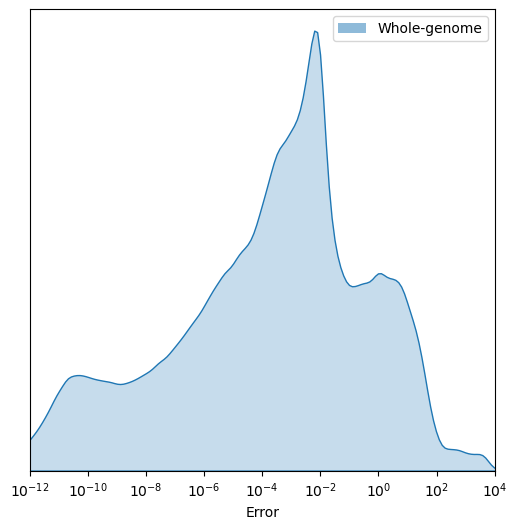

In [117]:
# Example usage
cell_lines = ["HeLa-S3"]#,"BJ1"]#,"IMR90","HUVEC","K562","GM12878","HepG2","MCF-7"]
chr_numbers = range(1,23)
tmin = 0
t1 = 500
t2 = 300
tmax = 500

early_errors, late_errors = gen_error_late_early(cell_lines, chr_numbers, tmin, t1, t2, tmax)

data_list = [early_errors]#, late_errors]
labels = ['Whole-genome']#, 'Late']

plot_relative_kdes(data_list, labels, log_scale=True, x_min=10**-12, x_max=10**5, plot_title="", bw_adjust=.8)

### Error distribution: AT vs GC regions

In [ ]:
# Generate AT/GC region files

import gzip
from Bio import SeqIO
import os

def save_genome_locations_by_base(local_genome_file, chr_lengths):
    bases = ['A', 'T', 'G', 'C']
    
    output_dir = 'data/reference_genome'
    os.makedirs(output_dir, exist_ok=True)
    
    with gzip.open(local_genome_file, "rt") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            chr_number = record.id.lstrip("chr")  # Removing 'chr' prefix
            if chr_number.isdigit():
                chr_number = int(chr_number)
                if chr_number in range(1, 23):  # Assuming we only want chromosomes 1-22
                    seq = str(record.seq).upper()  # Ensure sequence is uppercase
                    base_files = {base: [] for base in bases}
                    
                    for kb in range(chr_lengths[chr_number-1]):
                        position = kb * 1000  # 0-based position
                        if position < len(seq):
                            base_pair = seq[position]
                            if base_pair in base_files:
                                base_files[base_pair].append(kb)
                    
                    for base, locations in base_files.items():
                        with open(os.path.join(output_dir, f'{base}_genome_locations_chr[{chr_number}].txt'), 'w') as file:
                            for loc in locations:
                                file.write(f'{loc}\n')

# Example usage
local_genome_file = 'data/reference_genome/hg38.fa.gz'  # Replace with the actual path to your hg38.fa.gz
chr_lengths = [249251, 243200, 198023, 191155, 180916, 171116, 159139, 146365, 141214, 135535, 135007, 133852, 115170, 107350, 102532, 90355, 81196, 78078, 59129, 63026, 48130, 51305]

save_genome_locations_by_base(local_genome_file, chr_lengths)


In [68]:
import numpy as np
import os

def load_error_data(cell_line, chr_number):
    file_path = f'data/whole-genome_error/error_{cell_line}_chr[{chr_number}].txt'
    return np.loadtxt(file_path, dtype=float)

def load_missing_data(cell_line, chr_number):
    file_path = f'data/whole-genome_missing_data/missing_data_{cell_line}_chr[{chr_number}].txt'
    if os.path.exists(file_path):
        return np.loadtxt(file_path, dtype=int)
    else:
        return np.array([], dtype=int)

def load_genome_location(base, chr_number):
    file_path = f'data/reference_genome/{base}_genome_locations_chr[{chr_number}].txt'
    if os.path.exists(file_path):
        return np.loadtxt(file_path, dtype=int)
    else:
        return np.array([], dtype=int)

def gen_error_AT_GC(cell_lines, chr_numbers):
    all_errors_AT = []
    all_errors_GC = []

    for cell_line in cell_lines:
        for chr_number in chr_numbers:
            error_data = load_error_data(cell_line, chr_number)
            missing_data = load_missing_data(cell_line, chr_number)

            # Remove missing data points
            if len(missing_data) > 0:
                error_data = np.delete(error_data, missing_data)

            # Load genome locations for each base
            locations_A = load_genome_location('A', chr_number)
            locations_T = load_genome_location('T', chr_number)
            locations_G = load_genome_location('G', chr_number)
            locations_C = load_genome_location('C', chr_number)

            # Initialize lists for partitioned errors
            errors_A = error_data[locations_A[locations_A < len(error_data)]]
            errors_T = error_data[locations_T[locations_T < len(error_data)]]
            errors_G = error_data[locations_G[locations_G < len(error_data)]]
            errors_C = error_data[locations_C[locations_C < len(error_data)]]

            all_errors_AT.extend(errors_A)
            all_errors_AT.extend(errors_T)
            all_errors_GC.extend(errors_G)
            all_errors_GC.extend(errors_C)

    # Ensure no zero values before log transformation
    all_errors_AT = np.array(all_errors_AT)
    all_errors_GC = np.array(all_errors_GC)
    all_errors_AT = all_errors_AT[all_errors_AT > 0]
    all_errors_GC = all_errors_GC[all_errors_GC > 0]

    return all_errors_AT, all_errors_GC

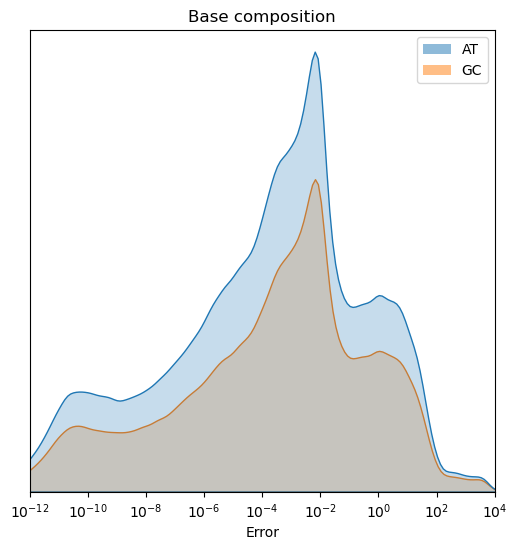

In [71]:
# Example usage
cell_lines = ["HeLa-S3"]#,"BJ1","IMR90","HUVEC","K562","GM12878","HepG2","MCF-7"]
chr_numbers = range(1,23)
errors_AT, errors_GC = gen_error_AT_GC(cell_lines, chr_numbers)

data_list = [errors_AT, errors_GC]
labels = ['AT', 'GC']

plot_relative_kdes(data_list, labels, log_scale=True, x_min=10**-12, x_max=10**5, plot_title="Base composition", bw_adjust=.8)

### Error distribution: common fragile sites

In [96]:
# CFSs file creation

import pandas as pd
import numpy as np
import os

# Define the input file path and output directory
input_file = 'data/fragile_sites/humCFS-fragile_sites.csv'
output_dir = 'data/fragile_sites'
os.makedirs(output_dir, exist_ok=True)

# Read the CSV file
df = pd.read_csv(input_file)

# Process each column (chromosome)
for col in df.columns:
    if col.startswith('chr'):
        chr_number = col[3:]
        positions = []

        # Process each interval in the column
        for interval in df[col].dropna():
            start, end = interval.split('-')
            start_kb = int(round(int(start) / 1000))
            end_kb = int(round(int(end) / 1000))
            positions.extend(range(start_kb, end_kb + 1))

        # Export positions to a text file
        output_file = os.path.join(output_dir, f'fragile_site_position_chr[{chr_number}].txt')
        np.savetxt(output_file, np.array(positions, dtype=int), fmt='%d')

In [79]:
import numpy as np
import os

def load_error_data(cell_line, chr_number):
    file_path = f'data/whole-genome_error/error_{cell_line}_chr[{chr_number}].txt'
    return np.loadtxt(file_path, dtype=float)

def load_missing_data(cell_line, chr_number):
    file_path = f'data/whole-genome_missing_data/missing_data_{cell_line}_chr[{chr_number}].txt'
    if os.path.exists(file_path):
        return np.loadtxt(file_path, dtype=int)
    else:
        return np.array([], dtype=int)

def gen_fragile_site_positions(chr_numbers, site_letters):
    # Load the CSV file
    csv_path = 'data/fragile_sites/humCFS-fragile_sites.csv'
    df = pd.read_csv(csv_path, header=None)
    
    fragile_site_positions = []

    for chromosome in chr_numbers:
        for site_letter in site_letters:
            # Find the column corresponding to the given chromosome
            col_index = chromosome - 1  # Chromosome 1 corresponds to column 0, and so on

            if col_index >= df.shape[1]:
                raise ValueError(f"Chromosome {chromosome} not found in the CSV file.")

            # Find the row corresponding to the given site letter
            row_index = ord(site_letter.upper()) - ord('A')  # 'A' corresponds to row 0, 'B' to row 1, and so on

            if row_index >= df.shape[0]:
                raise ValueError(f"Site letter {site_letter} not found in the CSV file for chromosome {chromosome}.")

            # Extract the range in the form chrposmin-chrposmax
            site_range = df.iloc[row_index, col_index]

            if pd.isna(site_range):
                # Return an empty list if there is no data
                fragile_site_positions.append(np.array([]))
                continue

            # Split the range into minimum and maximum positions
            pos_min, pos_max = map(int, site_range.split('-'))

            # Convert positions to kb
            pos_min_kb = pos_min // 1000
            pos_max_kb = pos_max // 1000

            # Append the range as a numpy array
            fragile_site_positions.append(np.arange(pos_min_kb, pos_max_kb))

    return fragile_site_positions

def gen_error_CFGs(cell_lines, chr_numbers, site_letters):
    all_fragile_site_errors = []
    all_whole_genome_errors = []
    all_non_cfs_errors = []
    genome_size = 0

    fragile_site_positions = gen_fragile_site_positions(chr_numbers, site_letters)

    for cell_line in cell_lines:
        for chr_index, chr_number in enumerate(chr_numbers):
            # Load error data and fragile site positions
            error_data = load_error_data(cell_line, chr_number)
            fragile_positions_chr = fragile_site_positions[chr_index]
            missing_data = load_missing_data(cell_line, chr_number)

            # Remove missing data points
            if len(missing_data) > 0:
                error_data = np.delete(error_data, missing_data)

            # Get errors for fragile site positions
            fragile_site_errors = error_data[fragile_positions_chr[fragile_positions_chr < len(error_data)]]
            all_fragile_site_errors.extend(fragile_site_errors)
            all_whole_genome_errors.extend(error_data)

            # Get errors for non-fragile site positions
            non_cfs_positions = np.setdiff1d(np.arange(len(error_data)), fragile_positions_chr)
            non_cfs_errors = error_data[non_cfs_positions]
            all_non_cfs_errors.extend(non_cfs_errors)

            # Update genome size
            genome_size += len(error_data)

    # Ensure no zero values before log transformation
    all_fragile_site_errors = np.array(all_fragile_site_errors)
    all_whole_genome_errors = np.array(all_whole_genome_errors)
    all_non_cfs_errors = np.array(all_non_cfs_errors)
    all_fragile_site_errors = all_fragile_site_errors[all_fragile_site_errors > 0]
    all_whole_genome_errors = all_whole_genome_errors[all_whole_genome_errors > 0]
    all_non_cfs_errors = all_non_cfs_errors[all_non_cfs_errors > 0]

    return all_whole_genome_errors, all_fragile_site_errors, all_non_cfs_errors

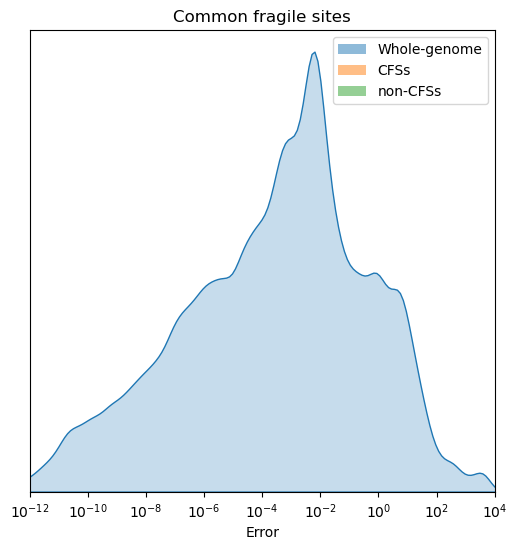

In [87]:
# Example usage
cell_lines = ['HeLa-S3']
chr_numbers = range(1,23)
site_letters = ['A', 'B']
whole_genome_errors, fragile_site_errors, non_cfs_errors = gen_error_CFGs(cell_lines, chr_numbers, site_letters)

data_list = [whole_genome_errors, fragile_site_errors, non_cfs_errors]
data_list = [fragile_site_errors]
labels = ['Whole-genome', 'CFSs', 'non-CFSs']

plot_relative_kdes(data_list, labels, log_scale=True, x_min=10**-12, x_max=10**5, plot_title="Common fragile sites", bw_adjust=.8)

# BCS file generation

### Main BCS file function

In [123]:
from random import random
import numpy as np
import sys
from math import floor
np.set_printoptions(threshold=sys.maxsize)

def bcs_gen(cell_line, chr_number, chrpos_min, chrpos_max, fork_speed, fire_rates, resolution):

    file_name = cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max)
    
    bcfile = 'code\DNAReplication.bc'
    new_bcfile = r'code\bcs_scripts\DNAReplication_'+cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max) + '.bc'
    bcsfile = []
    
    chrLength = chrpos_max - chrpos_min
    orign = int(chrLength * resolution / 1000)
    fast = 100000
    x = np.linspace(chrpos_min, chrpos_max, chrLength)  # Chromosome positions
    
    with open(bcfile, 'r') as file:
        bcsfile = file.readlines()
    bcsfile[bcsfile.index("// Chromosome length\n")+1] = "L = "+str(chrLength)+";\n"
    bcsfile[bcsfile.index("// Fast rate\n")+1] = "fast = "+str(fast)+";\n"
    bcsfile[bcsfile.index("// Fork velocity\n")+1] = "v = "+str(fork_speed)+";\n"
    
    oril = list(map(floor, np.linspace(1, chrLength, num=orign)))
    
    flistn = fire_rates
    
    # write new origins
    oriarr = np.array([
        'ORI[' + str(floor(oril[i1])) + ',' + '{:.30f}'.format(flistn[i1]) + ']'
        for i1 in range(0, orign)
    ])
    
    # delete all the origins
    with open(new_bcfile, 'w') as fp:
        for number, line in enumerate(bcsfile):
            if number not in range(bcsfile.index("// PROCESS INITIATION\n")+1, bcsfile.index("// END")-2):
                fp.write(line)
        
    # now change the last line
    with open(new_bcfile, 'r') as file:
        bcsfile = file.readlines()
        bcsfile[bcsfile.index("// PROCESS INITIATION\n")+1] = str(oriarr).replace('"','').replace("'",'').replace(" "," || ")[1:-1]+';\n'
    
    with open(new_bcfile, 'w') as file:
        file.writelines(bcsfile)


### Example: BCS file generation

In [125]:
# These should be run using Beacon Calculus. HPC recommended.

# Single files #
sing_filesQ = False
if sing_filesQ:

    cell_line = "HeLa-S3"
    chr_number = 1
    chrpos_min = 3000
    chrpos_max = 3200
    fork_speed = 1.4
    resolution = 1000 # (1 kb)
    fire_rates = np.loadtxt('data/whole-genome_firing_rates/fire_rates_' + cell_line + '_chr[' + str(chr_number) + '].txt', dtype='float64')[chrpos_min:chrpos_max]
    
    bcs_gen(cell_line, chr_number, chrpos_min, chrpos_max, fork_speed, fire_rates, resolution)

# Multiple bcs generation (long computation) #
mult_fileQ = True
if mult_fileQ:
    
    cell_lines = ["HeLa-S3","BJ1","IMR90","HUVEC","K562","GM12878","HepG2","MCF-7"]
    chr_range = range(1,23)
    fork_speed = 1.4
    resolution = 1000
    
    for cell_line_i in cell_lines:
        
        for chr_number_i in chr_range:
            
            fire_rates = np.loadtxt('data/whole-genome_firing_rates/fire_rates_' + cell_line_i + '_chr[' + str(chr_number_i) + '].txt', dtype='float64')
            int_step = 10000 # sets the number of bcs simulation points
            partition_intervals = [[i, min(i + int_step, len(fire_rates))] for i in range(0, len(fire_rates), int_step)]
            
            for partition_intervals_i in partition_intervals:
                
                bcs_gen(cell_line_i, chr_number_i, partition_intervals_i[0], partition_intervals_i[1], fork_speed, fire_rates[partition_intervals_i[0]:partition_intervals_i[1]], resolution)

# BCS output

### Replication timing, fork directionality and origins

In [15]:
import numpy as np
import os

def process_bcs_output(cell_line, chr_number, chrpos_min, chrpos_max, fork_speed, resolution, scale_factor, sim_number, compute_replication_time, compute_fork_directionality, compute_origin_positions):
    # Define the file path
    file_path = f'data/bcs_output/bcs_output_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.simulation.bcs'

    # Initialize arrays to store replication time and fork directionality
    DNA_replicationtime = [0.0 for _ in range(0, chrpos_max - chrpos_min)] if compute_replication_time else None
    DNA_forkdirectionality = [0.0 for _ in range(0, chrpos_max - chrpos_min)] if compute_fork_directionality else None
    DNA_originpositions = [] if compute_origin_positions else None  # List to store origin positions per simulation
    current_origins = []
    sim_iteration = 0

    with open(file_path) as f:
        for line in f:
            if sim_iteration == sim_number + 1:
                break
            if line[0] == '>':
                alreadyDone = []
                if compute_origin_positions and current_origins:  # If we have collected origins for the current simulation
                    DNA_originpositions.append(current_origins)
                current_origins = []
                print(sim_iteration, end="\r")
                sim_iteration += 1
                continue
            splitLine = line.split('\t')
            if compute_origin_positions and splitLine[2] == "ORI":
                origin_pos = int(splitLine[4])
                current_origins.append(origin_pos)
            if splitLine[2] == "FL":
                pos = int(splitLine[4]) - 1
                time = float(splitLine[0])
                if pos not in alreadyDone:
                    if compute_replication_time:
                        DNA_replicationtime[pos] += time
                    if compute_fork_directionality:
                        DNA_forkdirectionality[pos] -= 1  # Track left-moving forks
                    alreadyDone.append(pos)
            if splitLine[2] == "FR":
                pos = int(splitLine[4]) - 1
                time = float(splitLine[0])
                if pos not in alreadyDone:
                    if compute_replication_time:
                        DNA_replicationtime[pos] += time
                    if compute_fork_directionality:
                        DNA_forkdirectionality[pos] += 1  # Track right-moving forks
                    alreadyDone.append(pos)

    # Don't forget to add the origins of the last simulation
    if compute_origin_positions and current_origins:
        DNA_originpositions.append(current_origins)

    # Average the results over the number of simulations
    if compute_replication_time:
        for i in range(len(DNA_replicationtime)):
            DNA_replicationtime[i] = float(DNA_replicationtime[i]) / float(sim_number)

    if compute_fork_directionality:
        for i in range(len(DNA_forkdirectionality)):
            DNA_forkdirectionality[i] = float(DNA_forkdirectionality[i]) / float(sim_number)

    # Define file paths for saving the results
    base_path = 'data'
    replication_time_path = os.path.join(base_path, 'whole-genome_timing_bcs', f'replication_time_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')
    fork_directionality_path = os.path.join(base_path, 'whole-genome_fork_directionality', f'fork_directionality_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')
    origin_positions_path = os.path.join(base_path, 'whole-genome_origins', f'origin_positions_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')

    # Create directories if they do not exist
    os.makedirs(os.path.dirname(replication_time_path), exist_ok=True)
    os.makedirs(os.path.dirname(fork_directionality_path), exist_ok=True)
    os.makedirs(os.path.dirname(origin_positions_path), exist_ok=True)

    # Save the results to text files
    if compute_replication_time:
        np.savetxt(replication_time_path, DNA_replicationtime, fmt='%.6f')

    if compute_fork_directionality:
        np.savetxt(fork_directionality_path, DNA_forkdirectionality, fmt='%.6f')

    if compute_origin_positions:
        with open(origin_positions_path, 'w') as f:
            for origins in DNA_originpositions:
                f.write(' '.join(map(str, origins)) + '\n')

### Interorigin distances

In [16]:
import numpy as np
import os

def compute_interorigin_distances(cell_line, chr_number, chrpos_min, chrpos_max):
    base_path = 'data'
    
    # Define file path for loading the origins
    origins_path = os.path.join(base_path, 'whole-genome_origins', f'origin_positions_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')
    
    # Load origins data from text file
    if os.path.exists(origins_path):
        with open(origins_path, 'r') as f:
            origins_data = [list(map(int, line.strip().strip('[]').split())) for line in f]
    else:
        raise FileNotFoundError(f"Origins data not found at {origins_path}")
    
    # Compute interorigin distances for each simulation
    interorigin_distances = []
    for origins in origins_data:
        origins_sorted = sorted(origins)
        distances = np.diff(origins_sorted)
        interorigin_distances.append(distances)
    
    # Define file path for saving the interorigin distances
    iod_path = os.path.join(base_path, 'whole-genome_interorigin_distances', f'iod_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')
    
    # Save interorigin distances to a text file
    with open(iod_path, 'w') as f:
        for distances in interorigin_distances:
            f.write(f"{list(distances)}\n")

### Example: bcs output data generation

In [ ]:
# Replication time, fork directionality and origins
process_bcs_output(
    cell_line='HeLa-S3',
    chr_number=1,
    chrpos_min=10000,
    chrpos_max=20000,
    fork_speed=1.4,
    resolution=1000,
    scale_factor=5,
    sim_number=20,
    compute_replication_time=True,
    compute_fork_directionality=True,
    compute_origin_positions=True
)

# Interorigin-distance
compute_interorigin_distances(
    cell_line='HeLa-S3',
    chr_number=1,
    chrpos_min=10000,
    chrpos_max=20000
)


### Plots

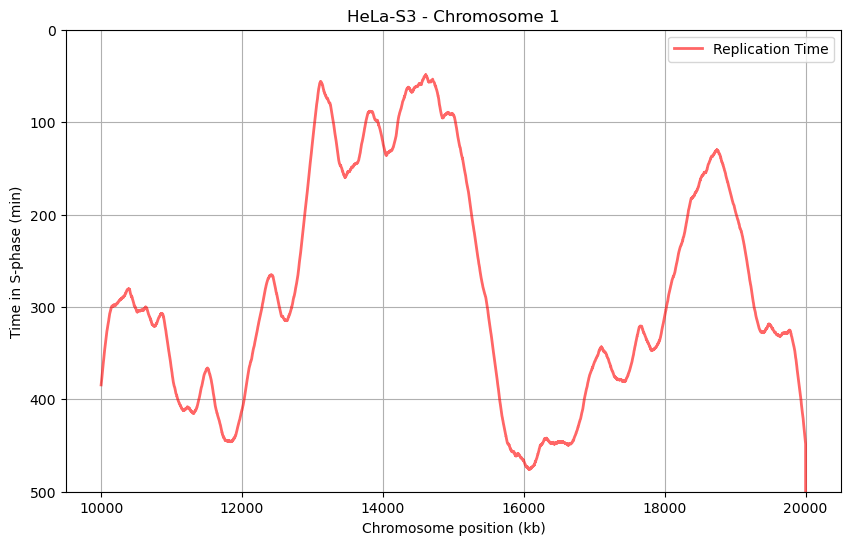

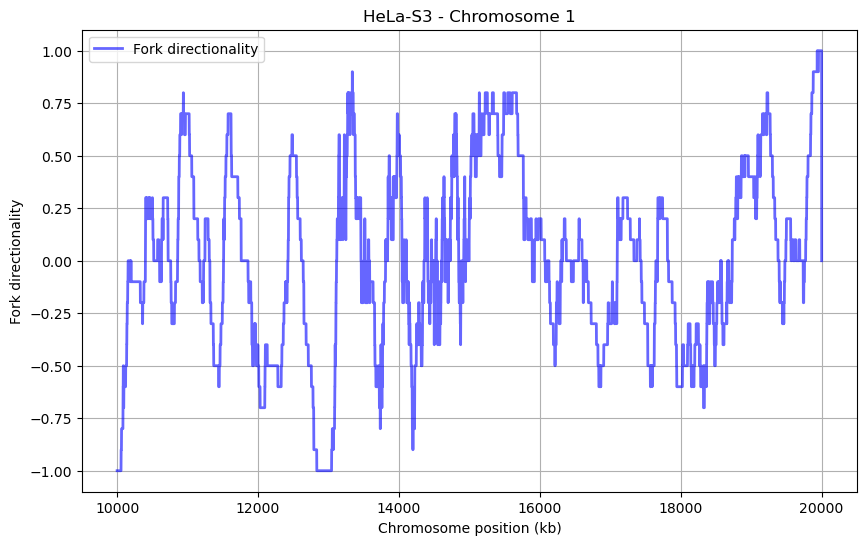

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_replication_data(cell_line, chr_number, chrpos_min, chrpos_max):
    base_path = 'data'

    # Define file paths for loading the results
    replication_time_path = os.path.join(base_path, 'whole-genome_timing_bcs', f'replication_time_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')
    fork_directionality_path = os.path.join(base_path, 'whole-genome_fork_directionality', f'fork_directionality_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')

    # Load data from text files
    if os.path.exists(replication_time_path):
        DNA_replicationtime = np.loadtxt(replication_time_path, dtype=float)
    else:
        raise FileNotFoundError(f"Replication time data not found at {replication_time_path}")

    if os.path.exists(fork_directionality_path):
        DNA_forkdirectionality = np.loadtxt(fork_directionality_path, dtype=float)
    else:
        raise FileNotFoundError(f"Fork directionality data not found at {fork_directionality_path}")

    # Generate chromosome positions
    x = np.linspace(chrpos_min, chrpos_max, chrpos_max - chrpos_min)

    # Plot replication time
    plt.figure(figsize=(10, 6))
    plt.plot(x, DNA_replicationtime, label='Replication Time', color='red', linewidth=2, alpha=0.6)
    plt.title(f'{cell_line} - Chromosome {chr_number}')
    plt.xlabel('Chromosome position (kb)')
    plt.ylabel('Time in S-phase (min)')
    plt.ylim(500, 0)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot fork directionality
    plt.figure(figsize=(10, 6))
    plt.plot(x, DNA_forkdirectionality, label='Fork directionality', color='blue', linewidth=2, alpha=0.6)
    plt.title(f'{cell_line} - Chromosome {chr_number}')
    plt.xlabel('Chromosome position (kb)')
    plt.ylabel('Fork directionality')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_replication_data(
    cell_line='HeLa-S3',
    chr_number=1,
    chrpos_min=10000,
    chrpos_max=20000
)

### Firing rate profiles

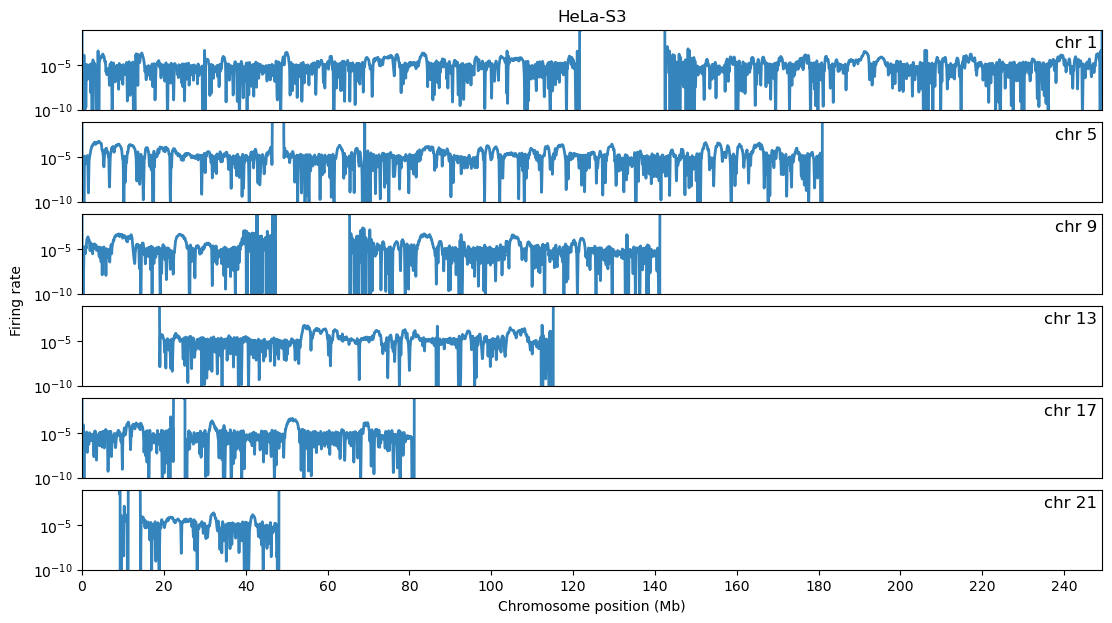

In [502]:
import matplotlib.pyplot as plt
import numpy as np

def fire_plotf(cell_line, chr_numbers, resolution, file_name, saveQ, aspect_ratio=(10, 6)):

    # Chromosome lengths in kb (1 kb resolution)
    chr_lengths = [249251, 243200, 198023, 191155, 180916, 171116, 159139, 146365, 141214, 135535, 135007, 133852, 115170, 107350, 102532, 90355, 81196, 78078, 59129, 63026, 48130, 51305]

    # Create subplots
    fig, axes = plt.subplots(len(chr_numbers), 1, figsize=aspect_ratio, sharey=True)

    for idx, chr_number in enumerate(chr_numbers):
        # Data loading: Read firing rates from a text file
        firing_rates_file_path = f'data/whole-genome_firing_rates/fire_rates_{cell_line}_chr[{chr_number}].txt'
        firing_rates = np.loadtxt(firing_rates_file_path, dtype=float)

        # Generate chromosome positions in Mb
        x = np.linspace(0, chr_lengths[chr_number - 1] / 1000, len(firing_rates))  # Chromosome positions in Mb

        # Plotting
        ax = axes[idx] if len(chr_numbers) > 1 else axes
        ax.plot(x, firing_rates, color='#1f77b4', linewidth=2, alpha=.9)
        
        if idx == 0:
            ax.set_title(f'{cell_line}')
        if idx == len(chr_numbers) - 1:
            ax.set_xlabel('Chromosome position (Mb)')
            ax.set_xticks(np.arange(0, chr_lengths[0] / 1000, 20))  # Set x-axis ticks to show every 20 Mb
        else:
            ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-axis ticks and labels for all but the last plot
        
        ax.set_yscale('log')
        ax.set_ylim(10**-10, 10**-1)
        ax.set_xlim(0, chr_lengths[0] / 1000)  # Set x-axis limit to the largest chromosome length in Mb
        ax.tick_params(axis='both', which='both', direction='out')
        for spine in ax.spines.values():
            spine.set_visible(True)
        
        # Add chromosome number on the top right corner with a transparent box
        ax.text(0.995, 0.93, f'chr {chr_number}', transform=ax.transAxes, 
                fontsize=12, verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0., edgecolor='none'))
        
        ax.grid(False)  # Remove grid for each plot

    # Add a shared y-axis label
    fig.text(0.04, 0.5, 'Firing rate', va='center', rotation='vertical')

    # Adjust layout
    plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05, hspace=0.15)  # Adjust margins and spacing

    # Save plot if saveQ is True
    if saveQ:
        plt.savefig(f'figures/fig_plot_fire_signatures_{cell_line}.svg', bbox_inches='tight', transparent=True)

    plt.show()

# Example usage
chr_numbers=range(1,23,4)
fire_plotf(
    cell_line='HeLa-S3', 
    chr_numbers=chr_numbers,
    resolution=1000, 
    file_name='firing_rates_plot', 
    saveQ=True,
    aspect_ratio=(12, len(chr_numbers))  # Customize the aspect ratio here
)

### Firing rate distribution per chromosome

In [106]:
import numpy as np
import os

def load_firing_rates(cell_line, chr_number):
    file_path = f'data/whole-genome_firing_rates/fire_rates_{cell_line}_chr[{chr_number}].txt'
    return np.loadtxt(file_path, dtype=float)

def gen_fire_rate(cell_line, chr_numbers):
    all_firing_rates = []

    for chr_number in chr_numbers:
        # Data loading: Read firing rates from a text file
        firing_rates = load_firing_rates(cell_line, chr_number)
        
        # Exclude the first and last 1000 points
        if len(firing_rates) > 2000:
            firing_rates = firing_rates[1000:-1000]
        else:
            raise ValueError("Firing rates data is too short to exclude the first and last 1000 points.")

        # Replace infinite values with NaN and exclude zero values and values outside the range [10^-10, 10^-1]
        firing_rates = firing_rates[np.isfinite(firing_rates) & (firing_rates != 0) & (firing_rates <= 10**-1) & (firing_rates >= 10**-10)]
        
        all_firing_rates.append(firing_rates)
    
    return all_firing_rates

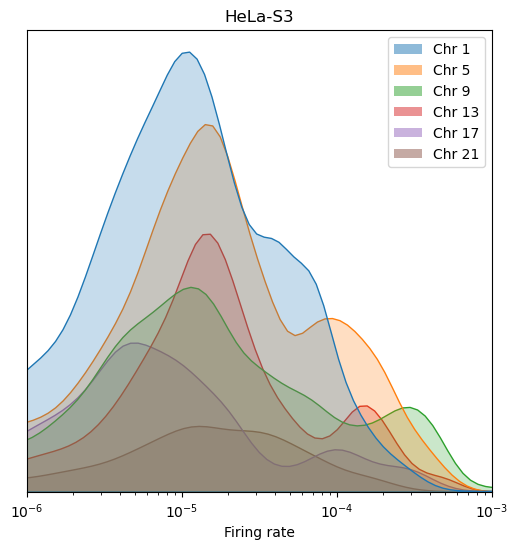

In [504]:
# Example usage
cell_line = 'HeLa-S3'
chr_numbers = range(1,23,4) #range(1,23)
firing_rates_list = gen_fire_rate(cell_line, chr_numbers)

data_list = firing_rates_list
labels = [f'Chr {i}' for i in chr_numbers]

plot_relative_kdes(data_list, labels, log_scale=True, x_min=10**-6, x_max=10**-3, plot_title=cell_line, x_title="Firing rate")

### Firing rate distribution per cell line

In [109]:
import numpy as np
import os

def load_firing_rates(cell_line, chr_number):
    file_path = f'data/whole-genome_firing_rates/fire_rates_{cell_line}_chr[{chr_number}].txt'
    return np.loadtxt(file_path, dtype=float)

def gen_fire_rate_whole(cell_lines, chr_numbers):
    all_firing_rates_per_cell_line = []

    for cell_line in cell_lines:
        all_firing_rates = []

        for chr_number in chr_numbers:
            # Data loading: Read firing rates from a text file
            firing_rates = load_firing_rates(cell_line, chr_number)
            
            # Exclude the first and last 1000 points
            if len(firing_rates) > 2000:
                firing_rates = firing_rates[1000:-1000]
            else:
                raise ValueError(f"Firing rates data for {cell_line} chr {chr_number} is too short to exclude the first and last 1000 points.")

            # Replace infinite values with NaN and exclude zero values and values outside the range [10^-10, 10^-1]
            firing_rates = firing_rates[np.isfinite(firing_rates) & (firing_rates != 0) & (firing_rates <= 10**-1) & (firing_rates >= 10**-10)]
            
            all_firing_rates.extend(firing_rates)
        
        all_firing_rates_per_cell_line.append(np.array(all_firing_rates))
    
    return all_firing_rates_per_cell_line

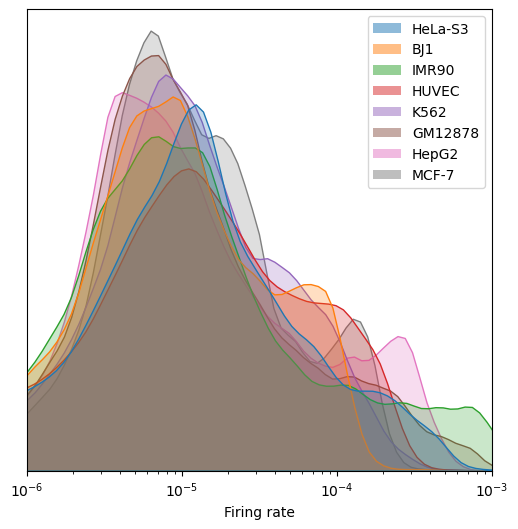

In [506]:
# Example usage
cell_lines = ["HeLa-S3"]#, "BJ1", "IMR90", "HUVEC", "K562", "GM12878", "HepG2", "MCF-7"]  # List of cell lines
chr_numbers = range(1,23)  # List of chromosome numbers to include
firing_rates_per_cell_line = gen_fire_rate_whole(cell_lines, chr_numbers)

data_list = firing_rates_per_cell_line
labels = cell_lines

plot_relative_kdes(data_list, labels, log_scale=True, x_min=10**-6, x_max=10**-3, plot_title="", x_title="Firing rate")